In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

In [4]:
# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

In [5]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

In [6]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 50)
        self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(50, 3)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

In [7]:
model     = Model(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.CrossEntropyLoss()
model

Model(
  (layer1): Linear(in_features=4, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=3, bias=True)
)

In [8]:
import tqdm

EPOCHS  = 100
X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

In [9]:
for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


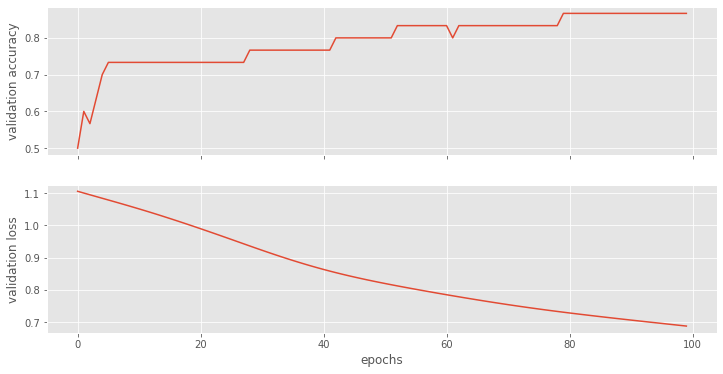

In [10]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


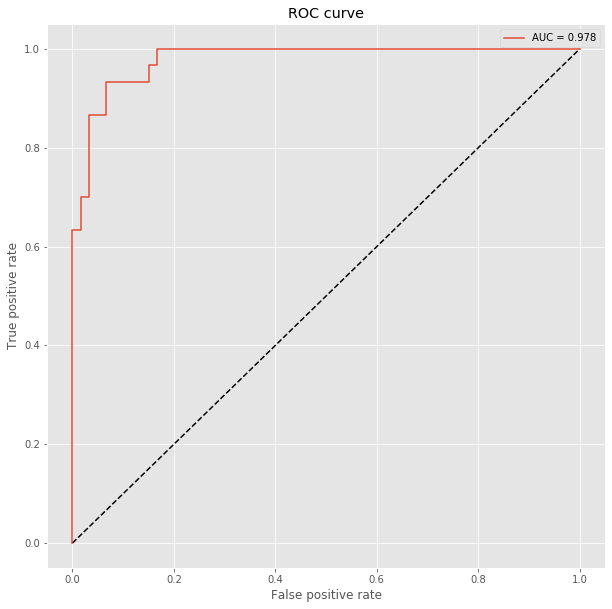

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

In [12]:
#Model function
def model_func(algorithm,dtrain_X,dtrain_Y,dtest_X,dtest_Y,cols=None):

    #algorithm.fit(dtrain_X,dtrain_Y)
    predictions = algorithm(dtest_X)
    prediction_probabilities = algorithm(dtest_X)
    print (algorithm)
    
    return predictions,prediction_probabilities,algorithm

In [13]:
model_func

<function __main__.model_func(algorithm, dtrain_X, dtrain_Y, dtest_X, dtest_Y, cols=None)>

In [14]:
model

Model(
  (layer1): Linear(in_features=4, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=3, bias=True)
)

In [15]:
y_pred,y_prob,model_obj=model_func(model,X_train,y_train,X_test,y_test)

Model(
  (layer1): Linear(in_features=4, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=3, bias=True)
)


In [16]:
from mosaicml import *
from mosaicml.constants import MLModelFlavours

/opt/conda/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [17]:
@scoring_func
def score(model, request):
    payload = request.json["payload"]
    data = pd.DataFrame(eval(payload))
    prediction = pd.Series(model(data))
    print (prediction)
    return prediction.tolist()

In [18]:
cols = ['SepalLen','SepalWid','PetalLen','PetalWid']

In [20]:
X[1]

array([4.9, 3. , 1.4, 0.2])

In [23]:
X_temp = pd.DataFrame([[4.9,3.0,1.4,0.2]],columns=cols)

In [24]:
import requests
req = requests.Request()
req.json = {"payload":X_temp.to_json(orient = 'records')}

In [26]:
req.json['payload']

'[{"SepalLen":4.9,"SepalWid":3.0,"PetalLen":1.4,"PetalWid":0.2}]'

In [32]:
list(X_temp.columns)

['SepalLen', 'SepalWid', 'PetalLen', 'PetalWid']

In [35]:
register_model(model_obj, score, name="Iris_ClassificationPYTORCH", 
                description="Iris flower classification",
                flavour=MLModelFlavours.pytorch, #schema=sch,
                y_true=y_test.detach().numpy(), y_pred = y_pred.detach().numpy(), #y_pred=pd.Series(y_pred), 
                prob=y_pred.detach().numpy(), features=list(X_temp.columns), 
               labels=["setosa","versicolor","virginica"], 
               init_script="" ,
                model_type="classification", 
                input_type="json", explain_ai=False, x_train=X_train.detach().numpy(), x_test=X_test.detach().numpy(), 
                y_train=y_train.detach().numpy(), y_test=y_test.detach().numpy(),
                feature_names=list(X_temp.columns),feature_ids=list(X_temp.columns),
                target_names=["0","1","2"], 
                kyd=False, kyd_score =False)
print("Registering model")

Calculating build time metrics

Progress: ██████████████████████████████████████████████████████████████████████ 100.0%


Registering model
